  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 9.3 MB/s eta 0:00:00
  Created wheel for genomic_benchmarks: filename=genomic_benchmarks-0.0.9-py3-none-any.whl size=22506 sha256=68028c2d724f3298e795dd313691eadb18df905e0ddcbd8f9cbd7771cb1c95ac
  Stored in directory: /root/.cache/pip/wheels/86/78/72/de9d75be800b6d679b8814b9663b3f610c34188b443b8b9b77
Successfully built genomic_benchmarks


/usr/local/lib/python3.10/dist-packages/genomic_benchmarks/utils/datasets.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Dataset `human_nontata_promoters` has 2 classes: negative, positive.

All lengths of genomic intervals equals 251.

Totally 36131 sequences have been found, 27097 for training and 9034 for testing.


Downloading...
From: https://drive.google.com/uc?id=1VdUg0Zu8yfLS6QesBXwGz1PIQrTW3Ze4
To: /root/.genomic_benchmarks/human_nontata_promoters.zip
100%|██████████| 11.8M/11.8M [00:00<00:00, 46.2MB/s]


Accuracy: 0.8038521142351118
Classification Report:               precision    recall  f1-score   support

           0       0.81      0.84      0.82      4915
           1       0.80      0.76      0.78      4119

    accuracy                           0.80      9034
   macro avg       0.80      0.80      0.80      9034
weighted avg       0.80      0.80      0.80      9034



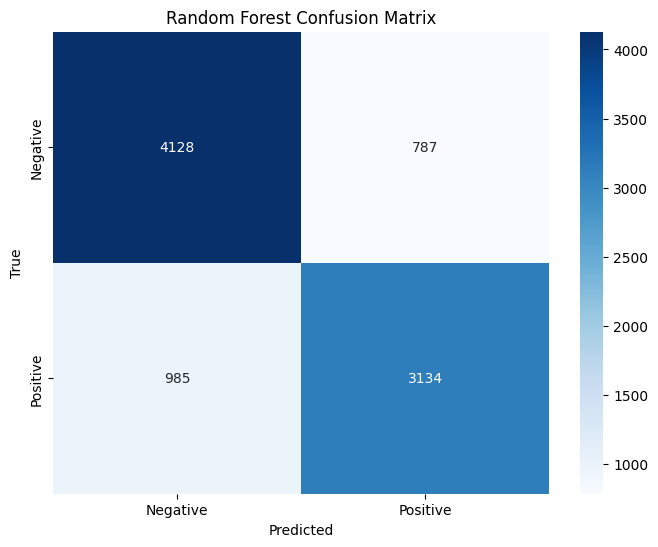

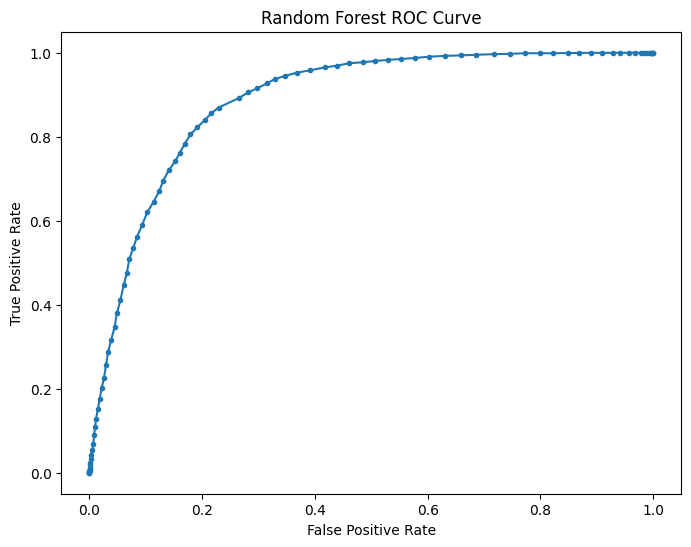

In [2]:
!pip install genomic_benchmarks
# List available datasets
from genomic_benchmarks.data_check import list_datasets

list_datasets()

# Display information about the "human_nontata_promoters" dataset with version 0
from genomic_benchmarks.data_check import info

info("human_nontata_promoters", version=0)

# Load the "human_nontata_promoters" dataset for training and testing
from genomic_benchmarks.dataset_getters.pytorch_datasets import HumanNontataPromoters

train = HumanNontataPromoters(split='train', version=0)
test = HumanNontataPromoters(split='test', version=0)

# Access a specific example from the training dataset (e.g., the 3000th sample)
train[3000]

import numpy as np

# Define a mapping of DNA bases to one-hot encoding
base_to_index = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

# Function to one-hot encode a DNA sequence, treating 'N' as missing data
def one_hot_encode(sequence, seq_length):
    encoded_sequence = np.zeros((seq_length, 4), dtype=int)
    for i, base in enumerate(sequence):
        if base in base_to_index:
            # Set the corresponding index to 1 for valid bases (A, C, G, T)
            encoded_sequence[i, base_to_index[base]] = 1
        else:
            # Treat 'N' as missing data (all zeros)
            encoded_sequence[i, :] = 0
    return encoded_sequence

# Apply one-hot encoding to the entire training and testing datasets
train_encoded = [one_hot_encode(item[0], len(item[0])) for item in train]
test_encoded = [one_hot_encode(item[0], len(item[0])) for item in test]

# Access the one-hot encoded sequence of the first sample in the training dataset
train_encoded[0]

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Extract labels from the training and testing datasets
train_labels = [item[1] for item in train]
test_labels = [item[1] for item in test]

# Reshape the one-hot encoded sequences into a two-dimensional format
train_encoded = np.array(train_encoded).reshape(len(train_encoded), -1)
test_encoded = np.array(test_encoded).reshape(len(test_encoded), -1)

# 2. Choose an Algorithm (Random Forest)
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# 3. Training the Model
rf_classifier.fit(train_encoded, train_labels)

# 4. Model Evaluation
predictions = rf_classifier.predict(test_encoded)
accuracy = accuracy_score(test_labels, predictions)
report = classification_report(test_labels, predictions)

print(f"Accuracy: {accuracy}")
print("Classification Report:", report)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create a confusion matrix for the Random Forest classifier
rf_cm = confusion_matrix(test_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Random Forest Confusion Matrix')
plt.show()


from sklearn.metrics import roc_curve, roc_auc_score

# Calculate ROC curve for Random Forest
rf_probs = rf_classifier.predict_proba(test_encoded)[:, 1]
rf_fpr, rf_tpr, _ = roc_curve(test_labels, rf_probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.show()

